https://www.kaggle.com/code/nageshsingh/build-knowledge-graph-using-python/notebook

## 1. Import packages

In [8]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
from spacy.lang.en.examples import sentences 
from nltk.corpus import stopwords
from textblob import Word

#spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline


In [3]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("../data/project_data/data-jobs-20221123.csv")
candidate_sentences.shape

candidate_sentences

,job_title,role,description
0,"Business Intelligence Engineer, Identity and Access Management",engineer,"· 3+ years in relevant experience as Business Intelligence Engineer, Data Engineer, Business Analyst, Data Scientist, or equivalent. · Proficiency with data querying or modeling technique with SQL..."
1,Data Integration Developer,developer,"· Using API connections and flat files ingests to parse JSON and CSV data for software connectors.\n· Develop connector software on Windows Red Hat Fuse using Java (version 8 or above), Blueprint ..."
2,Identity and Access Management (IDAM) Operations Analyst,analyst,** NO Corp-to-Corp**\n\n\nMust be local or willing to relocate at your own expense.\n\n\nPosition Summary\n\n\nIdentity and Access Management (IDAM) Operations Analyst is responsible for supportin...
3,Identity and Access Management Engineer - IAM (SailPoint IIQ),engineer,**REMOTE OPPORTUNITY**\r\n\r\nEmBark is currently seeking an experienced IAM specialist with specific skills within SailPoint IIQ. This is a highly visible role at the start of a multi-phase enter...
4,ServiceNow Developer (All Levels Remote),developer,"*We are open to supporting 100% remote work anywhere within the US.*\nICF’s Data Modernization Division is a rapidly growing, entrepreneurial, technology-driven department, seeking motivated Sr. S..."
...,...,...,...
447,Director Information Security-Privileged Access Management (PAM)- REMOTE OR HYBRID,leadership,"You Lead the Way. We’ve Got Your Back.\n\nWith the right backing, people and businesses have the power to progress in incredible ways. When you join Team Amex, you become part of a global and dive..."
448,ISD Engineer II/III (Customer Identity Access Management),engineer,"YOUR LIFE'S MISSION: POSSIBLE\n\nYou have goals, dreams, hobbies and things you’re passionate about.\n\n\nWhat’s Important to You Is Important to Us\nWe’re looking for people who not only want to ..."
449,Assoc. Identity & Access Management Analyst,analyst,YOUR PURPOSE AND FUNCTION IN OUR COMPANY:\nThe Associate Identity & Access Management Analyst is responsible for provisioning of access to Preferred Mutual Insurance employees and contract resourc...
450,Lead Identity and Access Management Engineer,engineer,"Your Role\n\nThe Identity Engineering team is responsible for the design, engineering, and operations of the Authentication and Authorization capabilities within the IAM department. The Identity E..."


In [4]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [9]:
## Lower case
candidate_sentences['description'] = candidate_sentences['description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
candidate_sentences['description'] = candidate_sentences['description'].str.replace('[^\w\s]',' ', regex=True)
## digits
candidate_sentences['description'] = candidate_sentences['description'].str.replace('\d+', ' ', regex=True)

#remove stop words
stop = stopwords.words('english')
other_stop_words = ['and','experience','show','veteran','less','origin','sexual', 'orientation', 'dental', 'insurance', 'hour', 'shift','religion','sex','receive','consideration','pay', 'per','employment','opportunity','consideration', 'employment','job','description','start', 'job','click','gender','benefits', 'k','monday', 'friday','age', 'disability','please', 'visit','salary', 'range','characteristic', 'protected','minimum', 'qualifications','join','reasonable', 'accommodation', 'parental', 'leave', 'medical', 'vision', 'duties', 'responsibilities','business', 'needs','essential', 'functions','color','type', 'fulltime','verbal', 'communication','apply','work','national', 'status','closely','flexible', 'spending','’','ability', 'work','location', 'remote','capital', 'one','marital', 'status','team', 'members','work', 'location','applicants', 'without','paid', 'time','color','regard', 'race','apply','equal', 'employer','without', 'regard','united', 'states',"'s",'race', 'color','best', 'practices','physical', 'mental','health', 'savings','responsible','affirmative', 'action','iam','federal','state','local','required','ideal', 'candidate','individuals', 'disabilities','northrop', 'grumman','applicable', 'law','every', 'day','across', 'organization''travel', 'required','track', 'record''including', 'limited','employee', 'assistance','new', 'york','compensation', 'package','financial', 'services','travel', 'requirements','including','provide','process','technology']

technical_words = ['support','system','environment','engineer','administrator','director','analyst', 'architect','specialist','developer','']

stop.extend(other_stop_words + technical_words)

candidate_sentences['description'] = candidate_sentences['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## lemmatization
candidate_sentences['description'] = candidate_sentences['description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print("Preprocessed data: \n")
candidate_sentences.head()


Preprocessed data: 



,job_title,role,description
0,"Business Intelligence Engineer, Identity and Access Management",engineer,year relevant intelligence data data scientist equivalent proficiency data querying modeling technique sql data visualization using quicksight tableau similar tool proficiency scripting language j...
1,Data Integration Developer,developer,using api connection flat file ingests parse json csv data software connector develop connector software window red hat fuse using java version blueprint xml xslt camel sql library ingests cyberse...
2,Identity and Access Management (IDAM) Operations Analyst,analyst,corp corp must willing relocate expense position summary identity access management idam operation supporting cybersecurity system integration effort large task order multiple government agency pe...
3,Identity and Access Management Engineer - IAM (SailPoint IIQ),engineer,embark currently seeking experienced specific skill within sailpoint iiq highly visible role multi phase enterprise level initiative year software design development least year development identit...
4,ServiceNow Developer (All Levels Remote),developer,open supporting anywhere within u icf data modernization division rapidly growing entrepreneurial driven department seeking motivated sr servicenow developer level upcoming customer data moderniza...


In [10]:
entity_pairs = []

for i in tqdm(candidate_sentences["description"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 452/452 [00:19<00:00, 23.27it/s]


In [11]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [12]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['description'])]

100%|██████████| 452/452 [00:18<00:00, 24.69it/s]


In [13]:
pd.Series(relations).value_counts()[:35]

include            24
believe            10
report              9
make                7
permitted           6
requires            6
help                5
relocate            5
understand          5
ensure              5
change              5
send                5
provides            5
deliver             4
communicates        4
provided            4
bring               4
demonstrated        4
consider            4
think               4
know                4
focused             4
maintain            4
allow               4
access              3
let                 3
com                 3
organize            3
want                3
use                 3
thought             3
elect               3
posse excellent     3
posted              3
desired             3
dtype: int64

In [14]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,related field amazon,legally www amazon application,include
1,improvement,cybersecurity program dod cybersecurity compliance,parse
2,secret eod clearance,casp ce cissp gslc cciso,dhs
3,full contract schedule sailpoint,automated exposure expert provisioning,includes
4,needed eeo transparency statement,puerto rico pr,facilitate wireless
...,...,...,...
447,flex enterprise working model,three poster report,thought
448,referral referral program,generated application,expected
449,mutual company employee,change rescind assignment,add
450,prototyping design engineering capacity,analyzes summary recommendation participates,maintains


In [15]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

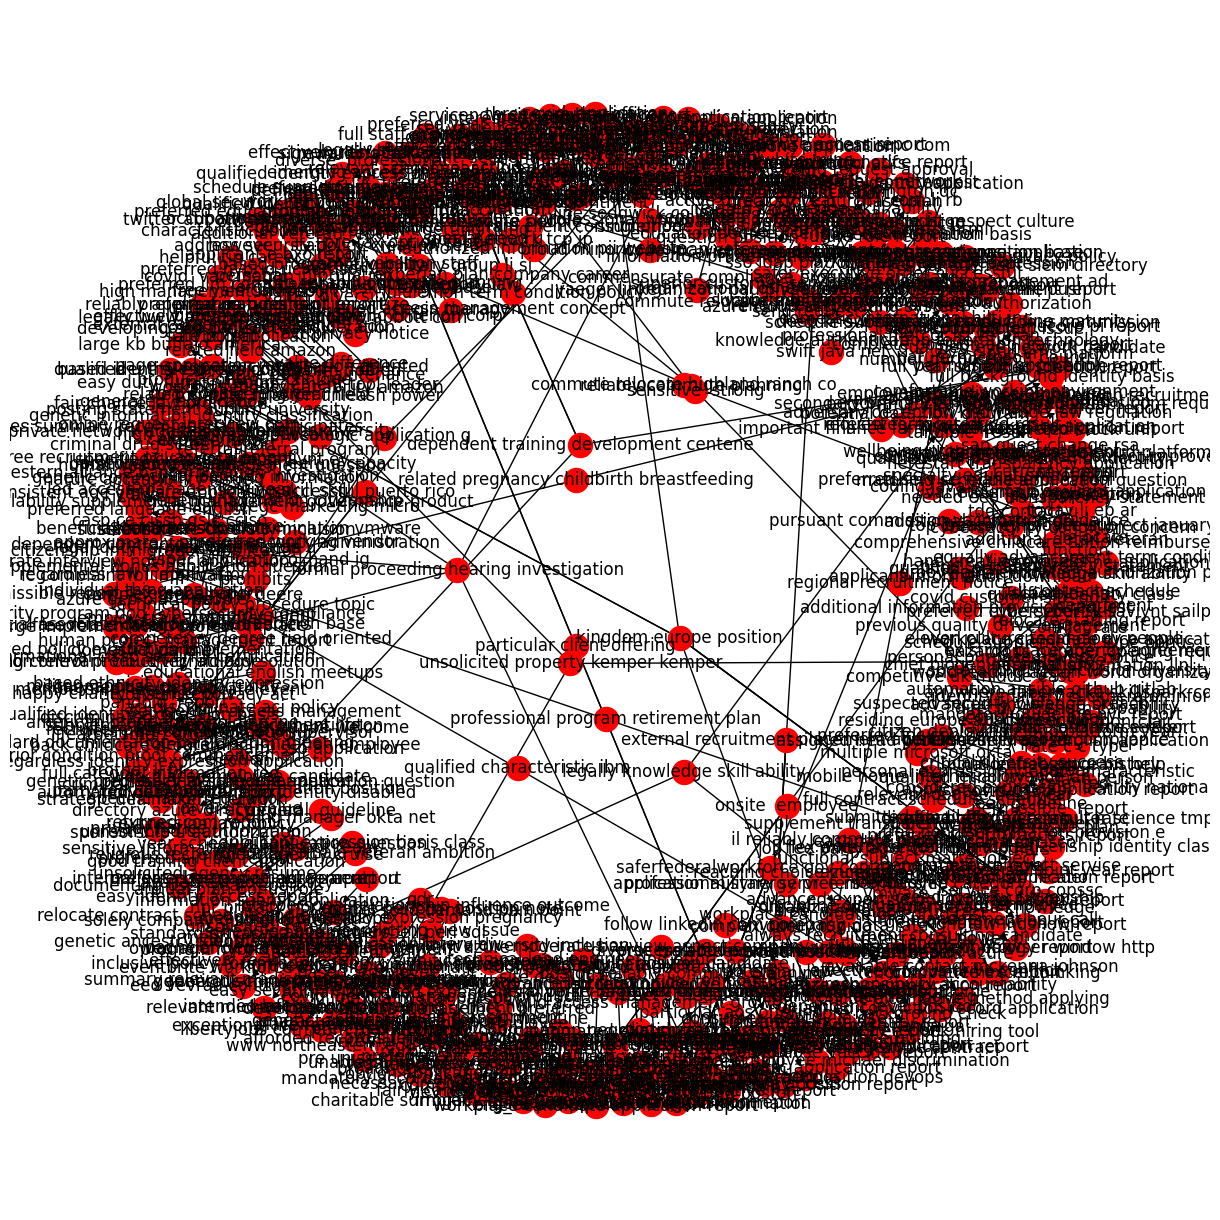

In [16]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

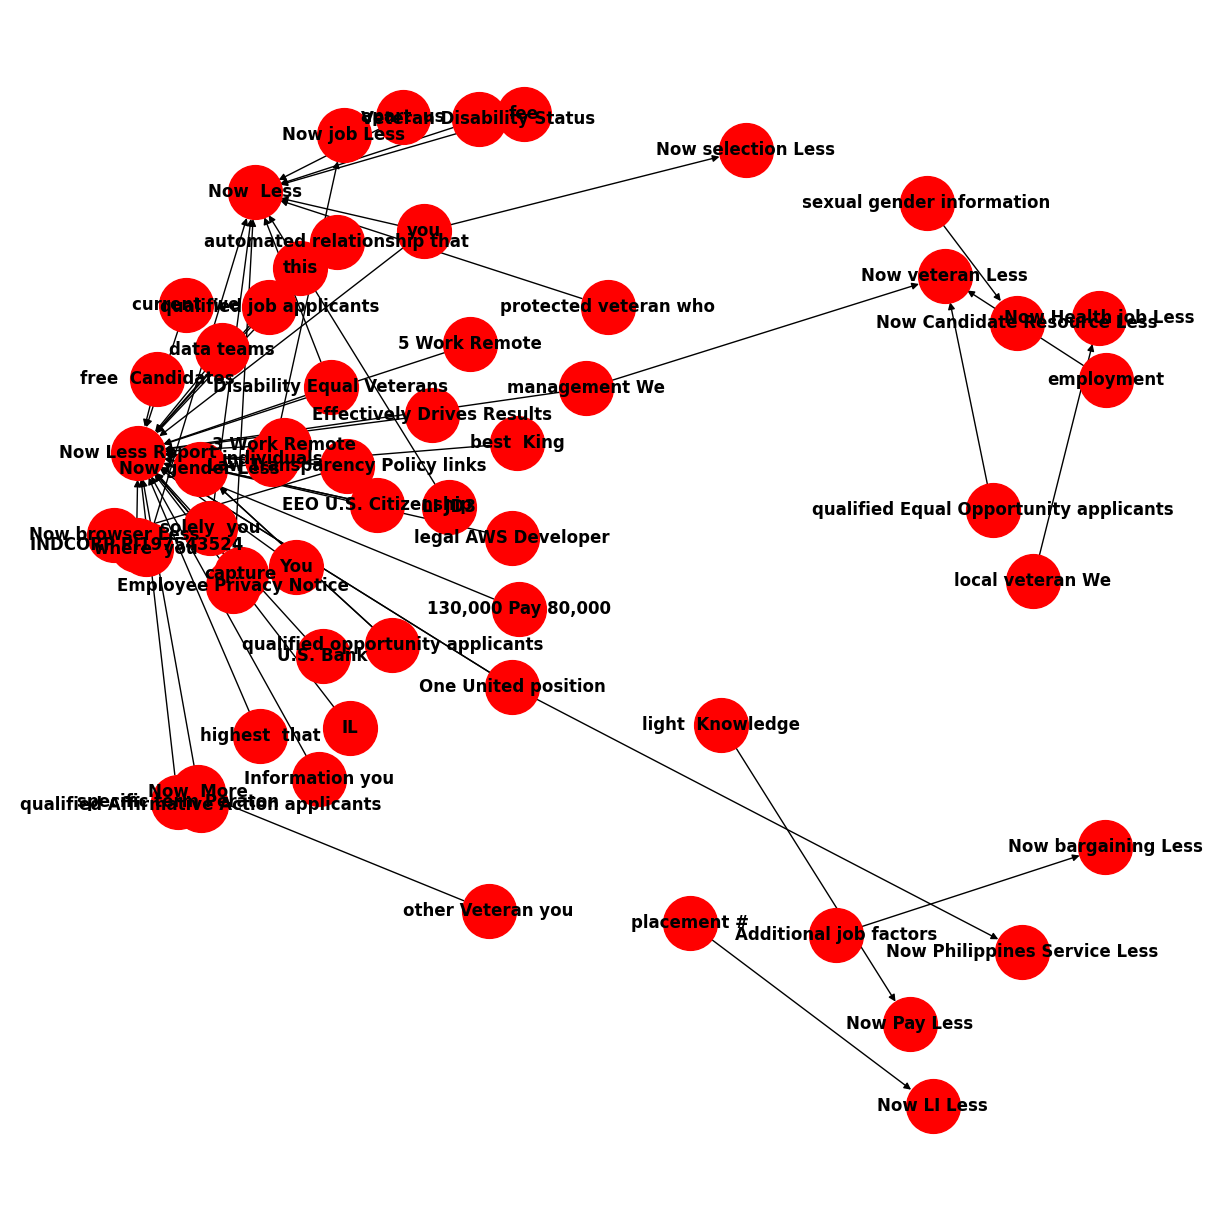

In [39]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="Apply"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
plt.show()